## RL for PdM
- Gem Version
- 1st working version 26-Jul-2025
- SIT data, PPO and REINFORCE

In [70]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='install "ipywidgets" for Jupyter support')

In [71]:
# --- Configuration ---
data_csv = 'data\SIT_D1_small.csv'
WEAR_THRESHOLD = 290.0
EPISODES = 10_000 # Working eps = 10_000
N_ENVS = 4 

R1 = 70.0  # Reward for good preventive replacement
R2 = -15.0  # Penalty for premature replacement
R3 = 5.0  # Minor reward for corrective action, better late than never

In [72]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import os
import torch
from torch import nn
import time
from typing import Any, Dict, Optional, Type, Union, Tuple
import matplotlib.pyplot as plt # Import matplotlib for plotting

from stable_baselines3 import PPO # Import PPO
from stable_baselines3.common.on_policy_algorithm import OnPolicyAlgorithm
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.utils import explained_variance, get_schedule_fn
from stable_baselines3.common.vec_env import VecEnv

Total timesteps: 10000


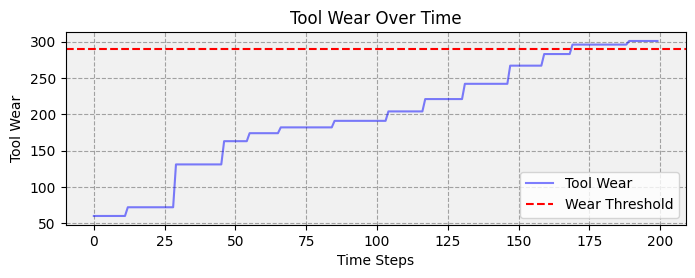

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

sensor_data_file = data_csv
df = pd.read_csv(sensor_data_file)
n_records = len(df.index)

TOTAL_TIMESTEPS = n_records * EPISODES # Reduced for quicker comparison run
# TOTAL_TIMESTEPS = EPISODES
print(f"Total timesteps: {TOTAL_TIMESTEPS}")

fig, ax = plt.subplots(figsize=(8, 2.5))  # Set plot size

ax.set_facecolor('#f1f1f1')  # Faint grey background for plot area only

ax.plot(df['tool_wear'], label='Tool Wear', color='blue', alpha=0.5)
ax.axhline(y=WEAR_THRESHOLD, color='red', linestyle='--', label='Wear Threshold')

ax.set_title('Tool Wear Over Time')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Tool Wear')
ax.grid(True, color='grey', linestyle='--', alpha=0.7)  # Mid grey grid
ax.legend()

plt.show()

In [74]:
# ==============================================================================
# 1. Custom Gymnasium Environment (G_ENV)
# ==============================================================================
class G_ENV(gym.Env):
    """
    Custom Gymnasium Environment for preventive tool-wear replacement.

    The environment simulates a tool's operation based on sensor data from a CSV file.
    The agent's goal is to decide whether to 'CONTINUE' using the tool or 'REPLACE_TOOL'
    to maximize tool usage while preventing tool wear from exceeding a threshold.
    """

    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(self, sensor_data_file, R1=7.0, R2=-2.0, R3=1.0, wear_threshold=270.0):
        """
        Initializes the G_ENV environment.

        Args:
            sensor_data_file (str): Path to the CSV file containing sensor data.
            wear_threshold (float): The tool wear threshold.
            R1 (float): Reward for good preventive replacement.
            R2 (float): Penalty for premature replacement.
            R3 (float): Reward for corrective replacement.
        """
        super().__init__()

        if not os.path.exists(sensor_data_file):
            raise FileNotFoundError(f"Sensor data file not found: {sensor_data_file}")

        self.sensor_data = pd.read_csv(sensor_data_file)
        self.wear_threshold = wear_threshold
        self.current_step = 0
        self.max_steps = len(self.sensor_data) - 1
        self.R1 = R1
        self.R2 = R2
        self.R3 = R3

        # Define the features that constitute the observation
        self.observation_features = [
            'Vib_Spindle', 'Vib_Table', 'Sound_Spindle', 'Sound_table',
            'X_Load_Cell', 'Y_Load_Cell', 'Z_Load_Cell', 'Current'
        ]

        # Define the observation space from the data
        low = self.sensor_data[self.observation_features].min().values.astype(np.float32)
        high = self.sensor_data[self.observation_features].max().values.astype(np.float32)
        self.observation_space = spaces.Box(low=low, high=high, dtype=np.float32)

        # Define the action space: 0 for CONTINUE, 1 for REPLACE_TOOL
        self.action_space = spaces.Discrete(2)

    def _get_obs(self):
        """Gets the current observation from the sensor data."""
        step = min(self.current_step, self.max_steps)
        return self.sensor_data.iloc[step][self.observation_features].values.astype(np.float32)

    def _get_info(self):
        """Gets additional information about the current state."""
        step = min(self.current_step, self.max_steps)
        current_wear = self.sensor_data.iloc[step]['tool_wear']
        return {
            "current_step": self.current_step,
            "tool_wear": current_wear,
            "wear_threshold": self.wear_threshold
        }

    def reset(self, seed=None, options=None):
        """Resets the environment to its initial state."""
        super().reset(seed=seed)
        self.current_step = 0
        observation = self._get_obs()
        info = self._get_info()
        return observation, info

    def step(self, action):
        """Performs one step in the environment given an action."""
        reward = 0
        terminated = False
        truncated = False

        current_tool_wear = self.sensor_data.iloc[self.current_step]['tool_wear']

        if action == 0:  # CONTINUE
            if current_tool_wear < self.wear_threshold:
                reward = 1  # Encourage using the tool if wear is low
            else:
                reward = -100  # Major penalty for not replacing when needed
                terminated = True # Episode ends due to critical failure
            self.current_step += 1

        elif action == 1:  # REPLACE_TOOL
            if current_tool_wear < self.wear_threshold:
                # Preventive replacement
                if current_tool_wear >= (self.wear_threshold - 20):
                    reward = self.R1  # Good preventive replacement
                else:
                    reward = self.R2  # Penalty for premature replacement
            else:
                # Corrective replacement
                reward = self.R3  # Reward for corrective action
            terminated = True  # Episode always terminates after replacement

        # Check for truncation (end of data)
        if self.current_step > self.max_steps:
            truncated = True
            if not terminated:
                reward = 0

        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, truncated, info

    def render(self):
        pass

    def close(self):
        pass

# ==============================================================================
# 2. REINFORCE Algorithm Implementation (SB3 Style)
# ==============================================================================
class REINFORCE(OnPolicyAlgorithm):
    """
    REINFORCE Algorithm (also known as Monte-Carlo Policy Gradient).

    This implementation is designed to follow the Stable Baselines3 structure,
    making it compatible with SB3 policies, wrappers, and utilities.
    """
    policy_aliases: Dict[str, Type[ActorCriticPolicy]] = {
        "MlpPolicy": ActorCriticPolicy,
    }

    def __init__(
        self,
        policy: Union[str, Type[ActorCriticPolicy]],
        env: Union[VecEnv, str],
        learning_rate: Union[float, callable] = 3e-4,
        n_steps: int = 1024,
        gamma: float = 0.99,
        tensorboard_log: Optional[str] = None,
        policy_kwargs: Optional[Dict[str, Any]] = None,
        verbose: int = 0,
        seed: Optional[int] = None,
        device: Union[torch.device, str] = "auto",
        _init_setup_model: bool = True,
    ):
        super().__init__(
            policy,
            env,
            learning_rate=learning_rate,
            n_steps=n_steps,
            gamma=gamma,
            gae_lambda=1.0, # Not used in REINFORCE, but required by parent
            ent_coef=0.0,   # No entropy regularization by default
            vf_coef=0.0,    # No value function by default
            max_grad_norm=0.5, # Standard value
            use_sde=False,
            sde_sample_freq=-1,
            tensorboard_log=tensorboard_log,
            policy_kwargs=policy_kwargs,
            verbose=verbose,
            device=device,
            seed=seed,
            _init_setup_model=False,
            supported_action_spaces=(spaces.Discrete,),
        )
        
        if _init_setup_model:
            self._setup_model()

    def _setup_model(self) -> None:
        super()._setup_model()

    def train(self) -> None:
        """
        The training loop for the REINFORCE algorithm.
        It collects a rollout, computes discounted returns for completed episodes,
        and updates the policy.
        """
        self.policy.set_training_mode(True)
        
        all_rewards = self.rollout_buffer.rewards
        all_episode_starts = self.rollout_buffer.episode_starts

        completed_episode_returns = []
        completed_episode_obs_indices = []
        
        for env_idx in range(self.n_envs):
            env_rewards = all_rewards[:, env_idx]
            env_episode_starts = all_episode_starts[:, env_idx]

            episode_end_markers = np.where(env_episode_starts)[0]
            episode_end_indices = episode_end_markers - 1
            episode_end_indices = episode_end_indices[episode_end_indices >= 0]
            
            start_idx = 0
            for end_idx in episode_end_indices:
                episode_rewards = env_rewards[start_idx : end_idx + 1]
                
                discounted_returns = []
                current_return = 0.0
                for reward in reversed(episode_rewards):
                    current_return = reward + self.gamma * current_return
                    discounted_returns.insert(0, current_return)
                
                completed_episode_returns.extend(discounted_returns)
                
                for i in range(start_idx, end_idx + 1):
                    global_idx = i * self.n_envs + env_idx
                    completed_episode_obs_indices.append(global_idx)
                
                start_idx = end_idx + 1

        if not completed_episode_obs_indices:
            if self.verbose > 1:
                print("No completed episodes in this rollout. Skipping update.")
            return

        flat_observations = self.rollout_buffer.observations.reshape(-1, *self.observation_space.shape)
        flat_actions = self.rollout_buffer.actions.reshape(-1)

        obs_tensor = torch.as_tensor(flat_observations[completed_episode_obs_indices], device=self.device)
        actions_tensor = torch.as_tensor(flat_actions[completed_episode_obs_indices], device=self.device)
        returns_tensor = torch.as_tensor(completed_episode_returns, dtype=torch.float32, device=self.device)

        returns_tensor = (returns_tensor - returns_tensor.mean()) / (returns_tensor.std() + 1e-8)

        _, log_prob, _ = self.policy.evaluate_actions(obs_tensor, actions_tensor)

        policy_loss = -(returns_tensor * log_prob).mean()

        self.policy.optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
        self.policy.optimizer.step()

        self.logger.record("train/policy_loss", policy_loss.item())
        self.logger.record("train/n_updates", self._n_updates, exclude="tensorboard")

    def learn(
        self,
        total_timesteps: int,
        callback: Any = None,
        log_interval: int = 1,
        tb_log_name: str = "REINFORCE",
        reset_num_timesteps: bool = True,
        progress_bar: bool = False,
    ) -> "REINFORCE":
        return super().learn(
            total_timesteps=total_timesteps,
            callback=callback,
            log_interval=log_interval,
            tb_log_name=tb_log_name,
            reset_num_timesteps=reset_num_timesteps,
            progress_bar=progress_bar,
        )

# ==============================================================================
# 3. Custom Callback for Logging
# ==============================================================================
class EpisodeStatsCallback(BaseCallback):
    """
    A custom callback to log episode rewards and lengths during training.
    """
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []

    def _on_step(self) -> bool:
        for done, info in zip(self.locals['dones'], self.locals['infos']):
            if done and 'episode' in info:
                ep_info = info['episode']
                self.episode_rewards.append(ep_info['r'])
                self.episode_lengths.append(ep_info['l'])
                self.logger.record("rollout/ep_rew_mean", np.mean(self.episode_rewards[-100:]))
                self.logger.record("rollout/ep_len_mean", np.mean(self.episode_lengths[-100:]))
        return True


In [75]:
# ==============================================================================
# 4. Main Execution Block
# ==============================================================================
    
if not os.path.exists(data_csv):
    print(f"Error: Data file '{data_csv}' not found.")
    print("Please ensure the CSV file is in the same directory as the script.")
else:
    print("--- Initializing Vectorized Environment ---")
    vec_env = make_vec_env(
        G_ENV,
        n_envs=N_ENVS,
        env_kwargs={'sensor_data_file': data_csv, 'wear_threshold': WEAR_THRESHOLD, 'R1': R1, 'R2': R2, 'R3': R3},
    )
    
    stats_callback = EpisodeStatsCallback()

    # --- Train REINFORCE Agent ---
    print("\n--- Initializing REINFORCE Model ---")
    reinforce_model = REINFORCE(
        "MlpPolicy",
        vec_env,
        verbose=0,
        n_steps=512, 
        gamma=0.95,
        learning_rate=5e-4,
        tensorboard_log="./maintenance_tensorboard/"
    )
    print("\n--- Starting REINFORCE Training ---")
    reinforce_model.learn(
        total_timesteps=TOTAL_TIMESTEPS, 
        callback=stats_callback, 
        progress_bar=True,
        tb_log_name="REINFORCE"
    )
    reinforce_model_path = "models\model_RF.zip"
    reinforce_model.save(reinforce_model_path)
    print(f"REINFORCE model saved to {reinforce_model_path}")

--- Initializing Vectorized Environment ---

--- Initializing REINFORCE Model ---

--- Starting REINFORCE Training ---


REINFORCE model saved to models\model_RF.zip



--- Generating Learning Curves ---


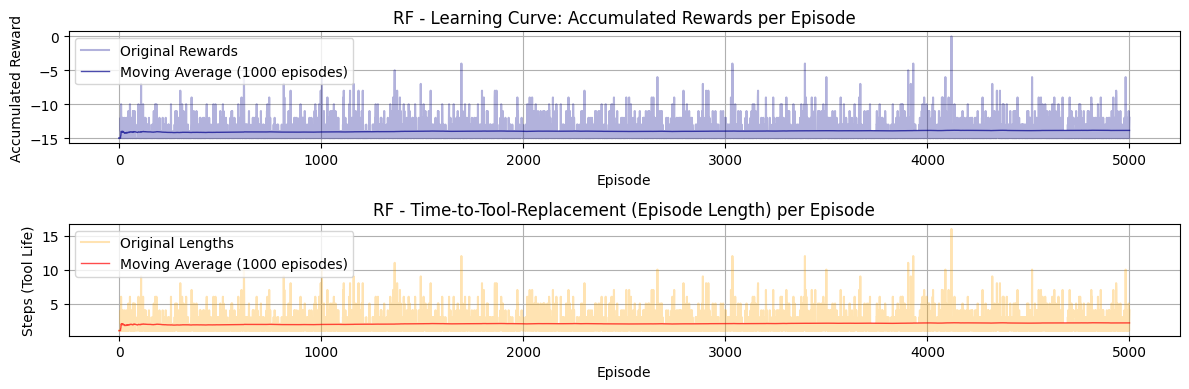

In [76]:
# --- Plotting Learning Curves ---
print("\n--- Generating Learning Curves ---")
# Ensure there's data to plot
if stats_callback.episode_rewards and stats_callback.episode_lengths:
    # Calculate moving averages
    window_size = 1000
    # Ensure window_size does not exceed the length of the data
    actual_window_rewards = min(window_size, len(stats_callback.episode_rewards))
    actual_window_lengths = min(window_size, len(stats_callback.episode_lengths))

    if actual_window_rewards > 0:
        moving_avg_rewards = pd.Series(stats_callback.episode_rewards).rolling(window=actual_window_rewards, min_periods=1).mean()
    else:
        moving_avg_rewards = []

    if actual_window_lengths > 0:
        moving_avg_lengths = pd.Series(stats_callback.episode_lengths).rolling(window=actual_window_lengths, min_periods=1).mean()
    else:
        moving_avg_lengths = []


    plt.figure(figsize=(12, 4)) # Adjusted figure size for two plots stacked vertically

    # Plot 1: Accumulated Rewards (Learning Curve)
    plt.subplot(2, 1, 1) # 2 rows, 1 column, first plot
    plt.plot(stats_callback.episode_rewards, label='Original Rewards', color='darkblue', alpha=0.3)
    if len(moving_avg_rewards) > 0:
        plt.plot(moving_avg_rewards, linewidth=1, label=f'Moving Average ({window_size} episodes)', color='darkblue', alpha=0.7)
    plt.title('RF - Learning Curve: Accumulated Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Accumulated Reward')
    plt.grid(True)
    plt.legend()

    # Plot 2: Time-to-Tool-Replacement (Episode Length)
    plt.subplot(2, 1, 2) # 2 rows, 1 column, second plot
    plt.plot(stats_callback.episode_lengths, alpha=0.3, label='Original Lengths', color='orange')
    if len(moving_avg_lengths) > 0:
        plt.plot(moving_avg_lengths, linewidth=1, label=f'Moving Average ({window_size} episodes)', color='red', alpha=0.7)
    plt.title('RF - Time-to-Tool-Replacement (Episode Length) per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Steps (Tool Life)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show() # This will display the plots

In [77]:
# --- Train PPO Agent ---
print("\n--- Initializing PPO Model ---")
# Note how similar the initialization is to our custom REINFORCE class
ppo_model = PPO(
    "MlpPolicy",
    vec_env,
    verbose=0,
    n_steps=1, # 512,
    gamma=0.95,
    learning_rate=5e-4,
    tensorboard_log="./maintenance_tensorboard/"
)
print("\n--- Starting PPO Training ---")
ppo_model.learn(
    total_timesteps=TOTAL_TIMESTEPS, 
    callback=stats_callback, 
    progress_bar=True,
    tb_log_name="PPO"
)
ppo_model_path = "models\model_PPO.zip"
ppo_model.save(ppo_model_path)
print(f"PPO model saved to {ppo_model_path}")

vec_env.close()


--- Initializing PPO Model ---

--- Starting PPO Training ---


c:\Users\Rajesh\anaconda3\envs\RL\lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 4`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 4
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1 and n_envs=4)
  warnings.warn(


PPO model saved to models\model_PPO.zip



--- Generating Learning Curves ---


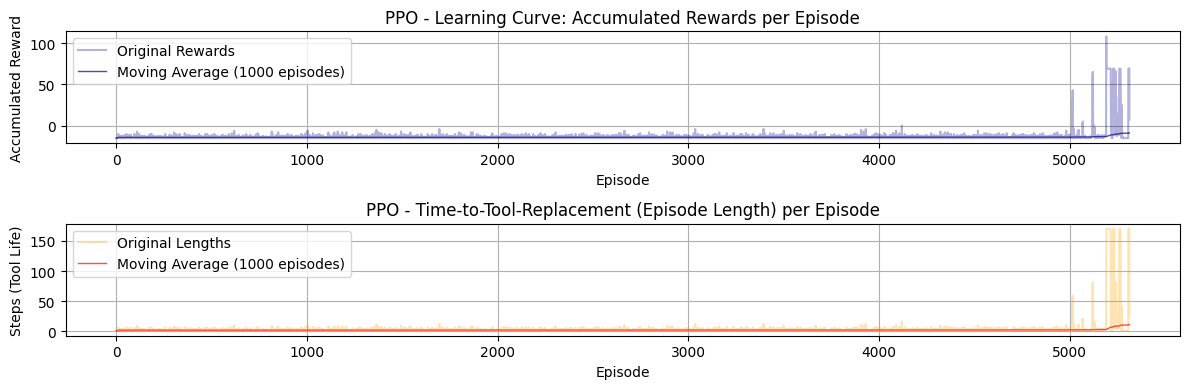

In [78]:
# --- Plotting Learning Curves ---
print("\n--- Generating Learning Curves ---")
# Ensure there's data to plot
if stats_callback.episode_rewards and stats_callback.episode_lengths:
    # Calculate moving averages
    window_size = 1000
    # Ensure window_size does not exceed the length of the data
    actual_window_rewards = min(window_size, len(stats_callback.episode_rewards))
    actual_window_lengths = min(window_size, len(stats_callback.episode_lengths))

    if actual_window_rewards > 0:
        moving_avg_rewards = pd.Series(stats_callback.episode_rewards).rolling(window=actual_window_rewards, min_periods=1).mean()
    else:
        moving_avg_rewards = []

    if actual_window_lengths > 0:
        moving_avg_lengths = pd.Series(stats_callback.episode_lengths).rolling(window=actual_window_lengths, min_periods=1).mean()
    else:
        moving_avg_lengths = []


    plt.figure(figsize=(12, 4)) # Adjusted figure size for two plots stacked vertically

    # Plot 1: Accumulated Rewards (Learning Curve)
    plt.subplot(2, 1, 1) # 2 rows, 1 column, first plot
    plt.plot(stats_callback.episode_rewards, label='Original Rewards', color='darkblue', alpha=0.3)
    if len(moving_avg_rewards) > 0:
        plt.plot(moving_avg_rewards, linewidth=1, label=f'Moving Average ({window_size} episodes)', color='darkblue', alpha=0.7)
    plt.title('PPO - Learning Curve: Accumulated Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Accumulated Reward')
    plt.grid(True)
    plt.legend()

    # Plot 2: Time-to-Tool-Replacement (Episode Length)
    plt.subplot(2, 1, 2) # 2 rows, 1 column, second plot
    plt.plot(stats_callback.episode_lengths, alpha=0.3, label='Original Lengths', color='orange')
    if len(moving_avg_lengths) > 0:
        plt.plot(moving_avg_lengths, linewidth=1, label=f'Moving Average ({window_size} episodes)', color='red', alpha=0.7)
    plt.title('PPO - Time-to-Tool-Replacement (Episode Length) per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Steps (Tool Life)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show() # This will display the plots

In [79]:
EPISODES, TOTAL_TIMESTEPS, n_records

(10000, 10000, 200)

In [80]:
# reinforce_model.save(reinforce_model_path)
# ppo_model.save(ppo_model_path)